## AAUtoSig Markdown
This document is a runthrough of our autoencoder model.
Firstly we initialise our installed packages

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.spatial as sp
import random

from functions import simulate_counts, plotsigs, cosine_cvx
from AAUtoSig_init import AAUtoSig, train_AAUtoSig

## Initialise the autoencoder
The following block creates a class to initialize a one-hidden-layer linear autoencoder, and a method for traning the one such model.

## Application
Now we can use our autoencoder on some simulated data

In [3]:
nsigs = 5

np.random.seed(20)
random.seed(20)
mf_df, true_sigs,_ = simulate_counts(5,3000, pentanucelotide=False)
tri = mf_df.index
mutation = [t[2:5] for t in tri]

#X = (mf_df / mf_df.sum(axis=0)).T
X = mf_df.T


#80/20 train/validation split
x_train = X.sample(frac=0.8)
x_val = X.drop(x_train.index)

#choosing the 'true' number of signatures
model = AAUtoSig(dim1 = nsigs)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss(reduction='mean')

# Using an Adam Optimizer with lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 1e-3)
                            
train_AAUtoSig(epochs = 500, 
            model = model, 
            x_train = x_train, 
            loss_function = loss_function, 
            optimizer = optimizer,
            batch_size=16)

x_test_tensor = torch.tensor(x_val.values, 
                             dtype = torch.float32)

rec_data = model(x_test_tensor)

#the weights of the decoding layer (dec1) is where we find the signatures.
sigs = model.dec1.weight.data    
sigs = pd.DataFrame(sigs.numpy()) 

(600, 96)
torch.Size([600, 96])


In [18]:
print(pd.DataFrame(rec_data).sum(axis = 1))
print(x_val.sum(axis = 1))
print(loss_function(rec_data, x_test_tensor))
print(np.mean(((x_val - rec_data.detach().numpy())**2).to_numpy()))

0      1181.031616
1       488.861786
2      1102.325439
3       420.056427
4       581.895386
          ...     
595     647.096252
596     422.432312
597     625.516785
598     162.427185
599     737.017639
Length: 600, dtype: float64
Patient5       1176.0
Patient8        487.0
Patient9       1101.0
Patient10       417.0
Patient22       578.0
                ...  
Patient2978     646.0
Patient2981     416.0
Patient2986     627.0
Patient2991     152.0
Patient2993     737.0
Length: 600, dtype: float64
tensor(0.0852, grad_fn=<MseLossBackward0>)
0.08523661958436189


In [ ]:
perm = cosine_cvx(sigs.T,true_sigs.T)[1]
sigs = sigs[perm]

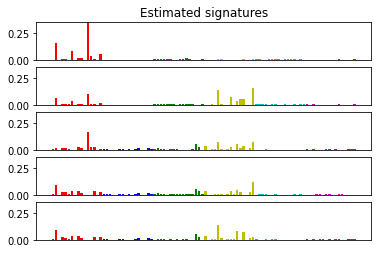

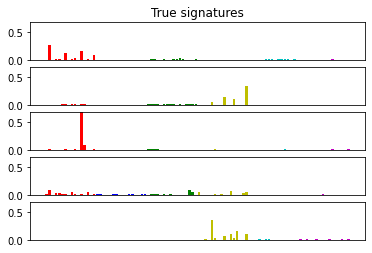

In [ ]:
#plot the results
plotsigs(tri, mutation, sigs.to_numpy(), nsigs, "Estimated signatures")  
plotsigs(tri, mutation, true_sigs.to_numpy(), nsigs, "True signatures")  